In [ ]:
# Print ablation summary table
def print_ablation_summary(ablations_data, baseline_data, method_name):
    """Print ablation summary comparing to baseline."""
    print(f"\n{'='*70}")
    print(f"Ablation Summary: {method_name}")
    print(f"{'='*70}")
    
    # Get baseline layer 0 value
    baseline_l0 = baseline_data.get(0, 0)
    print(f"Baseline (Layer 0): {baseline_l0:.1f}%\n")
    
    print(f"{'Ablation':<35} {'L0':>8} {'Δ vs Base':>12}")
    print("-" * 55)
    
    for model_key, label in ABLATION_NAMES.items():
        if model_key in ablations_data:
            l0 = ablations_data[model_key].get(0, 0)
            delta = l0 - baseline_l0
            sign = '+' if delta >= 0 else ''
            print(f"{label:<35} {l0:>7.1f}% {sign}{delta:>10.1f}%")

if 'ABLATIONS_DATA' in dir():
    print_ablation_summary(ABLATIONS_DATA.get('contextual', {}), BASELINE_CONTEXTUAL, 'Contextual V-Lens')
    print_ablation_summary(ABLATIONS_DATA.get('nn', {}), BASELINE_NN, 'Static NN')

In [ ]:
def create_ablation_mega_plot(ablations_data, baseline_data, method_name, output_path=None):
    """Create mega plot comparing all ablations against baseline."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    expected_layers = [0, 1, 2, 4, 8, 16, 24, 30, 31]  # OLMo layers
    
    # Plot baseline (thick black line)
    if baseline_data:
        layers = sorted([l for l in baseline_data.keys() if l in expected_layers])
        values = [baseline_data[l] for l in layers]
        ax.plot(layers, values, 'k-', linewidth=3, markersize=10, label='Baseline', zorder=100)
    
    # Color palette for ablations
    colors = plt.cm.tab10(np.linspace(0, 1, len(ABLATION_NAMES)))
    markers = ['o', 's', '^', 'v', 'D', 'p', '*', 'h', 'X', 'd']
    
    for (model_key, label), color, marker in zip(ABLATION_NAMES.items(), colors, markers):
        if model_key in ablations_data:
            layers = sorted([l for l in ablations_data[model_key].keys() if l in expected_layers])
            values = [ablations_data[model_key][l] for l in layers]
            ax.plot(layers, values, marker=marker, color=color, linewidth=2,
                   markersize=8, label=label, alpha=0.8)
    
    ax.set_xlabel('Layer', fontsize=16, fontweight='bold')
    ax.set_ylabel('Interpretable Tokens %', fontsize=16, fontweight='bold')
    ax.set_title(f'Ablations: {method_name}', fontsize=18, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    ax.set_xticks(expected_layers)
    ax.tick_params(labelsize=13)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=11, framealpha=0.95)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.png'), dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")
    
    plt.show()
    return fig

# Generate ablation mega plots
if 'ABLATIONS_DATA' in dir():
    ablation_output_dir = OUTPUT_DIR / 'ablations'
    ablation_output_dir.mkdir(exist_ok=True)
    
    # Contextual V-Lens mega plot
    if ABLATIONS_DATA.get('contextual'):
        fig_abl_ctx = create_ablation_mega_plot(
            ABLATIONS_DATA['contextual'], BASELINE_CONTEXTUAL,
            'Contextual V-Lens',
            output_path=ablation_output_dir / 'ablations_mega_contextual.pdf'
        )
    
    # Static NN mega plot (layer 0 only for most ablations)
    if ABLATIONS_DATA.get('nn'):
        fig_abl_nn = create_ablation_mega_plot(
            ABLATIONS_DATA['nn'], BASELINE_NN,
            'Static NN',
            output_path=ablation_output_dir / 'ablations_mega_nn.pdf'
        )

In [ ]:
# Load ablation data
BASELINE_KEY = 'olmo-7b_vit-l-14-336'

# Display names for ablations
ABLATION_NAMES = {
    'first-sentence_olmo-7b_vit-l-14-336': 'First-Sentence',
    'olmo-7b_vit-l-14-336_earlier-vit-layers-6': 'ViT Layer 6',
    'olmo-7b_vit-l-14-336_earlier-vit-layers-10': 'ViT Layer 10',
    'olmo-7b_vit-l-14-336_linear': 'Linear Connector',
    'olmo-7b_vit-l-14-336_seed10': 'Seed 10',
    'olmo-7b_vit-l-14-336_seed11': 'Seed 11',
    'olmo-7b_vit-l-14-336_unfreeze': 'Unfrozen LLM',
    'train_mlp-only_pixmo_topbottom_olmo-7b_vit-l-14-336': 'TopBottom (frozen)',
    'train_mlp-only_pixmo_topbottom_olmo-7b_vit-l-14-336_unfreeze-llm': 'TopBottom (unfrozen)'
}

if _data and 'ablations' in _data:
    ABLATIONS_DATA = _data['ablations']
    # Convert string keys to int for layer numbers
    for method in ['nn', 'contextual']:
        if method in ABLATIONS_DATA:
            ABLATIONS_DATA[method] = {
                model: {int(k): v for k, v in layers.items()}
                for model, layers in ABLATIONS_DATA[method].items()
            }
    print(f"✓ Loaded ablations data:")
    print(f"  NN: {len(ABLATIONS_DATA.get('nn', {}))} models")
    print(f"  Contextual: {len(ABLATIONS_DATA.get('contextual', {}))} models")
    
    # Get baseline from MAIN model data (not ablations - ablations folder has corrupted baseline)
    BASELINE_CONTEXTUAL = {int(k): v for k, v in _data['contextual'].get('olmo-7b+vit-l-14-336', {}).items()}
    BASELINE_NN = {int(k): v for k, v in _data['nn'].get('olmo-7b+vit-l-14-336', {}).items()}
    print(f"  Baseline (from main models): NN {len(BASELINE_NN)} layers, Contextual {len(BASELINE_CONTEXTUAL)} layers")
else:
    print("⚠ No ablations data found in data.json")

---
## Ablation Studies

Comparison of training variations against baseline (OLMo-7B + CLIP ViT-L/14):
- **Caption Style**: First-sentence only vs full captions
- **ViT Layers**: Earlier layers (6, 10) vs default (last)
- **Connector Type**: Linear vs MLP
- **Random Seeds**: Different initialization seeds
- **LLM Frozen**: Frozen vs unfrozen LLM
- **Training Task**: Captioning vs TopBottom spatial reasoning

In [ ]:
def create_qwen2vl_plot(nn_data, logitlens_data, contextual_data, output_path=None):
    """Create unified 3-panel plot for Qwen2-VL."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Qwen2-VL uses 28 layers, so expected layers are: 0, 1, 2, 4, 8, 16, 24, 26, 27
    expected_layers = [0, 1, 2, 4, 8, 16, 24, 26, 27]
    
    datasets = [
        (axes[0], nn_data, 'Static NN (Input Embedding)', '#2E86AB'),
        (axes[1], logitlens_data, 'LogitLens (Output Embedding)', '#A23B72'),
        (axes[2], contextual_data, 'LN-Lens (Contextual)', '#28A745'),
    ]
    
    for ax, data, title, color in datasets:
        if data:
            layers = sorted([l for l in data.keys() if l in expected_layers])
            values = [data[l] for l in layers]
            ax.plot(layers, values, 'o-', color=color, linewidth=2.5, markersize=10, label='Qwen2-VL-7B')
        
        ax.set_xlabel('Layer', fontsize=14, fontweight='bold')
        ax.set_ylabel('Interpretable Tokens %', fontsize=14, fontweight='bold')
        ax.set_title(title, fontsize=16, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
        ax.tick_params(labelsize=12)
        ax.set_xticks(expected_layers)
        ax.legend(fontsize=12)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.png'), dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")
    
    plt.show()
    return fig

# Generate Qwen2-VL plot
if 'QWEN2VL_NN' in dir():
    qwen2vl_output_dir = OUTPUT_DIR / 'qwen2vl'
    qwen2vl_output_dir.mkdir(exist_ok=True)
    
    fig_qwen2vl = create_qwen2vl_plot(
        QWEN2VL_NN, QWEN2VL_LOGITLENS, QWEN2VL_CONTEXTUAL,
        output_path=qwen2vl_output_dir / 'qwen2vl_unified.pdf'
    )

In [ ]:
# Load Qwen2-VL data
if _data and 'qwen2vl' in _data:
    QWEN2VL_DATA = _data['qwen2vl']
    # Convert string keys to int
    QWEN2VL_NN = {int(k): v for k, v in QWEN2VL_DATA.get('nn', {}).items()}
    QWEN2VL_LOGITLENS = {int(k): v for k, v in QWEN2VL_DATA.get('logitlens', {}).items()}
    QWEN2VL_CONTEXTUAL = {int(k): v for k, v in QWEN2VL_DATA.get('contextual', {}).items()}
    print(f"✓ Loaded Qwen2-VL data:")
    print(f"  NN: {len(QWEN2VL_NN)} layers, LogitLens: {len(QWEN2VL_LOGITLENS)} layers, Contextual: {len(QWEN2VL_CONTEXTUAL)} layers")
else:
    print("⚠ No Qwen2-VL data found in data.json")

# Main Paper Figures

This notebook contains all the data and plotting logic for the figures in the paper:
**"The surprising interpretability of vision tokens in LLMs"**

Each section contains:
1. The raw data needed for the plot
2. The plotting code

This notebook is self-contained and reproducible.


In [31]:
# Setup and imports
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
from pathlib import Path

# Set default style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.family'] = 'sans-serif'

# Output directory for figures
OUTPUT_DIR = Path('paper_figures_output')
OUTPUT_DIR.mkdir(exist_ok=True)
print(f"Figures will be saved to: {OUTPUT_DIR.absolute()}")


Figures will be saved to: /content/paper_figures_output


---
## Figure 1: Unified Interpretability Line Plot

Three-panel figure showing interpretability across layers for:
- (a) Nearest Neighbors (static V-Lens at input layer)
- (b) Logit Lens
- (c) Contextual NN (contextual V-Lens)

Each panel shows 9 model combinations (3 LLMs × 3 vision encoders).


In [32]:
# =============================================================================
# LOAD DATA from data.json (auto-generated by update_data.py)
# Run: python update_data.py   to refresh data from analysis_results/
# =============================================================================
import json
import urllib.request

DATA_URL = "https://raw.githubusercontent.com/BennoKrojer/molmo/interp/paper_plots/data.json"

def load_data():
    """Load data from local file or GitHub."""
    try:
        with open('data.json', 'r') as f:
            print("✓ Loaded from local data.json")
            return json.load(f)
    except FileNotFoundError:
        pass
    try:
        with urllib.request.urlopen(DATA_URL) as r:
            print("✓ Loaded from GitHub")
            return json.loads(r.read().decode())
    except Exception as e:
        print(f"⚠ Could not load data: {e}")
        return None

def fix_keys(d):
    """Convert string keys to int for layer numbers."""
    return {k: {int(layer): v for layer, v in layers.items()} for k, layers in d.items()}

_data = load_data()
if _data:
    NN_DATA = fix_keys(_data['nn'])
    LOGITLENS_DATA = fix_keys(_data['logitlens'])
    CONTEXTUAL_DATA = fix_keys(_data['contextual'])
    # Filter to only 9 main model combos
    MAIN_MODELS = [f"{l}+{e}" for l in ['olmo-7b','llama3-8b','qwen2-7b'] for e in ['vit-l-14-336','siglip','dinov2-large-336']]
    CONTEXTUAL_DATA = {k:v for k,v in CONTEXTUAL_DATA.items() if k in MAIN_MODELS}
    print(f"  NN: {len(NN_DATA)}, LogitLens: {len(LOGITLENS_DATA)}, Contextual: {len(CONTEXTUAL_DATA)} models")
else:
    raise RuntimeError("Could not load data!")


✓ Loaded from GitHub
  NN: 9, LogitLens: 9, Contextual: 9 models


In [33]:
# =============================================================================
# PLOTTING CONFIG: Colors, markers, labels, expected layers
# =============================================================================

# Display names for paper
LLM_DISPLAY_NAMES = {
    'llama3-8b': 'Llama3-8B',
    'olmo-7b': 'OLMo-7B',
    'qwen2-7b': 'Qwen2-7B'
}

ENCODER_DISPLAY_NAMES = {
    'vit-l-14-336': 'CLIP ViT-L/14',
    'siglip': 'SigLIP',
    'dinov2-large-336': 'DINOv2'
}

# Order for consistent legend
LLM_ORDER = ['olmo-7b', 'llama3-8b', 'qwen2-7b']
ENCODER_ORDER = ['vit-l-14-336', 'siglip', 'dinov2-large-336']

# Color scheme: each LLM gets a color family, encoders get shades
LLM_BASE_COLORS = {
    'olmo-7b': plt.cm.Blues,
    'llama3-8b': plt.cm.Greens,
    'qwen2-7b': plt.cm.Reds
}
ENCODER_SHADE_INDICES = [0.5, 0.7, 0.9]

# Markers for each encoder
ENCODER_MARKERS = {
    'vit-l-14-336': '*',       # star (filled)
    'siglip': 'o',             # circle (hollow)
    'dinov2-large-336': '^'    # triangle (filled)
}
ENCODER_MARKER_FACECOLORS = {
    'vit-l-14-336': None,      # filled
    'siglip': 'none',          # hollow
    'dinov2-large-336': None   # filled
}

# =============================================================================
# EXPECTED LAYERS: [0, 1, 2, 4, 8, 16, 24, N-2, N-1] where N varies per LLM
# =============================================================================

def get_expected_layers(llm):
    """
    Get the expected layers for a given LLM.
    We use: [0, 1, 2, 4, 8, 16, 24, N-2, N-1]
    where N = 32 for OLMo/Llama, N = 28 for Qwen
    """
    if llm in ['olmo-7b', 'llama3-8b']:
        return [0, 1, 2, 4, 8, 16, 24, 30, 31]
    elif llm == 'qwen2-7b':
        return [0, 1, 2, 4, 8, 16, 24, 26, 27]
    else:
        return [0, 1, 2, 4, 8, 16, 24, 30, 31]

def get_all_expected_layers():
    """Get union of all expected layers across all models."""
    return sorted(set(get_expected_layers('olmo-7b') + get_expected_layers('qwen2-7b')))

def filter_to_expected_layers(data):
    """Filter data to only include expected layers for each model."""
    filtered = {}
    for key, layer_data in data.items():
        llm = key.split('+')[0]
        expected = set(get_expected_layers(llm))
        filtered[key] = {k: v for k, v in layer_data.items() if k in expected}
    return filtered

# =============================================================================

def get_color_map():
    """Generate color mapping for all model combinations."""
    color_map = {}
    for llm in LLM_ORDER:
        base_cmap = LLM_BASE_COLORS[llm]
        for enc_idx, encoder in enumerate(ENCODER_ORDER):
            color_map[(llm, encoder)] = base_cmap(ENCODER_SHADE_INDICES[enc_idx])
    return color_map

def parse_model_key(key):
    """Parse 'llm+encoder' string into (llm, encoder) tuple."""
    parts = key.split('+')
    return parts[0], parts[1]

def get_display_label(llm, encoder):
    """Get display label for legend."""
    llm_label = LLM_DISPLAY_NAMES.get(llm, llm)
    encoder_label = ENCODER_DISPLAY_NAMES.get(encoder, encoder)
    return f"{llm_label} + {encoder_label}"


In [34]:
# =============================================================================
# PLOTTING FUNCTION: Unified 3-panel figure
# =============================================================================

def create_unified_lineplot(nn_data, logitlens_data, contextual_data,
                            output_path=None, figsize=(18, 5)):
    """
    Create unified figure with 3 subplots showing interpretability across layers.

    Args:
        nn_data: Dict of nearest neighbors data
        logitlens_data: Dict of logit lens data
        contextual_data: Dict of contextual NN data
        output_path: Path to save figure (optional)
        figsize: Figure size tuple
    """
    color_map = get_color_map()

    # Filter data to expected layers and get x-axis ticks
    nn_data = filter_to_expected_layers(nn_data)
    logitlens_data = filter_to_expected_layers(logitlens_data)
    contextual_data = filter_to_expected_layers(contextual_data)
    all_expected_layers = get_all_expected_layers()

    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=figsize)

    subplot_configs = [
        {'ax': axes[0], 'data': nn_data, 'title': 'Input Embedding Matrix', 'xlabel': 'Layer'},
        {'ax': axes[1], 'data': logitlens_data, 'title': 'Output Embedding Matrix (Logitlens)', 'xlabel': 'Layer'},
        {'ax': axes[2], 'data': contextual_data, 'title': 'LN-Lens', 'xlabel': 'Layer'},
    ]

    handles_dict = {}

    for config in subplot_configs:
        ax = config['ax']
        data = config['data']

        if not data:
            continue

        # Plot lines for each model combination
        for llm in LLM_ORDER:
            for encoder in ENCODER_ORDER:
                key = f"{llm}+{encoder}"
                if key not in data:
                    continue

                layer_data = data[key]
                layers = sorted(layer_data.keys())
                values = [layer_data[l] for l in layers]

                if len(layers) == 0:
                    continue

                label = get_display_label(llm, encoder)
                marker = ENCODER_MARKERS.get(encoder, 'o')
                marker_facecolor = ENCODER_MARKER_FACECOLORS.get(encoder)
                color = color_map[(llm, encoder)]

                if marker_facecolor is not None:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   markerfacecolor=marker_facecolor,
                                   markeredgewidth=2, linewidth=2.5, markersize=10)
                else:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   linewidth=2.5, markersize=10)

                if label not in handles_dict:
                    handles_dict[label] = line

        # Customize subplot
        ax.set_xlabel(config['xlabel'], fontsize=14, fontweight='bold')
        ax.set_ylabel('Interpretable Tokens %\n(via automated judge)', fontsize=14, fontweight='bold')
        ax.set_title(config['title'], fontsize=16, fontweight='bold', pad=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
        ax.tick_params(axis='both', labelsize=11)

        # Set x-axis to show only expected layers
        ax.set_xlim(min(all_expected_layers) - 0.5, max(all_expected_layers) + 0.5)
        ax.set_xticks(all_expected_layers)
        ax.set_xticklabels([str(t) for t in all_expected_layers])

    # Create shared legend at bottom
    ordered_handles = []
    ordered_labels = []
    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            label = get_display_label(llm, encoder)
            if label in handles_dict:
                ordered_handles.append(handles_dict[label])
                ordered_labels.append(label)

    fig.legend(ordered_handles, ordered_labels,
              loc='lower center',
              bbox_to_anchor=(0.5, -0.12),
              ncol=3,
              fontsize=12,
              framealpha=0.9,
              columnspacing=2.0,
              handlelength=2.5)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.22, wspace=0.25)

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {output_path}")
        # Also save PNG
        png_path = Path(output_path).with_suffix('.png')
        plt.savefig(png_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {png_path}")

    plt.show()
    return fig


Saved: paper_figures_output/interpretability/fig1_unified_interpretability.pdf
Saved: paper_figures_output/interpretability/fig1_unified_interpretability.png


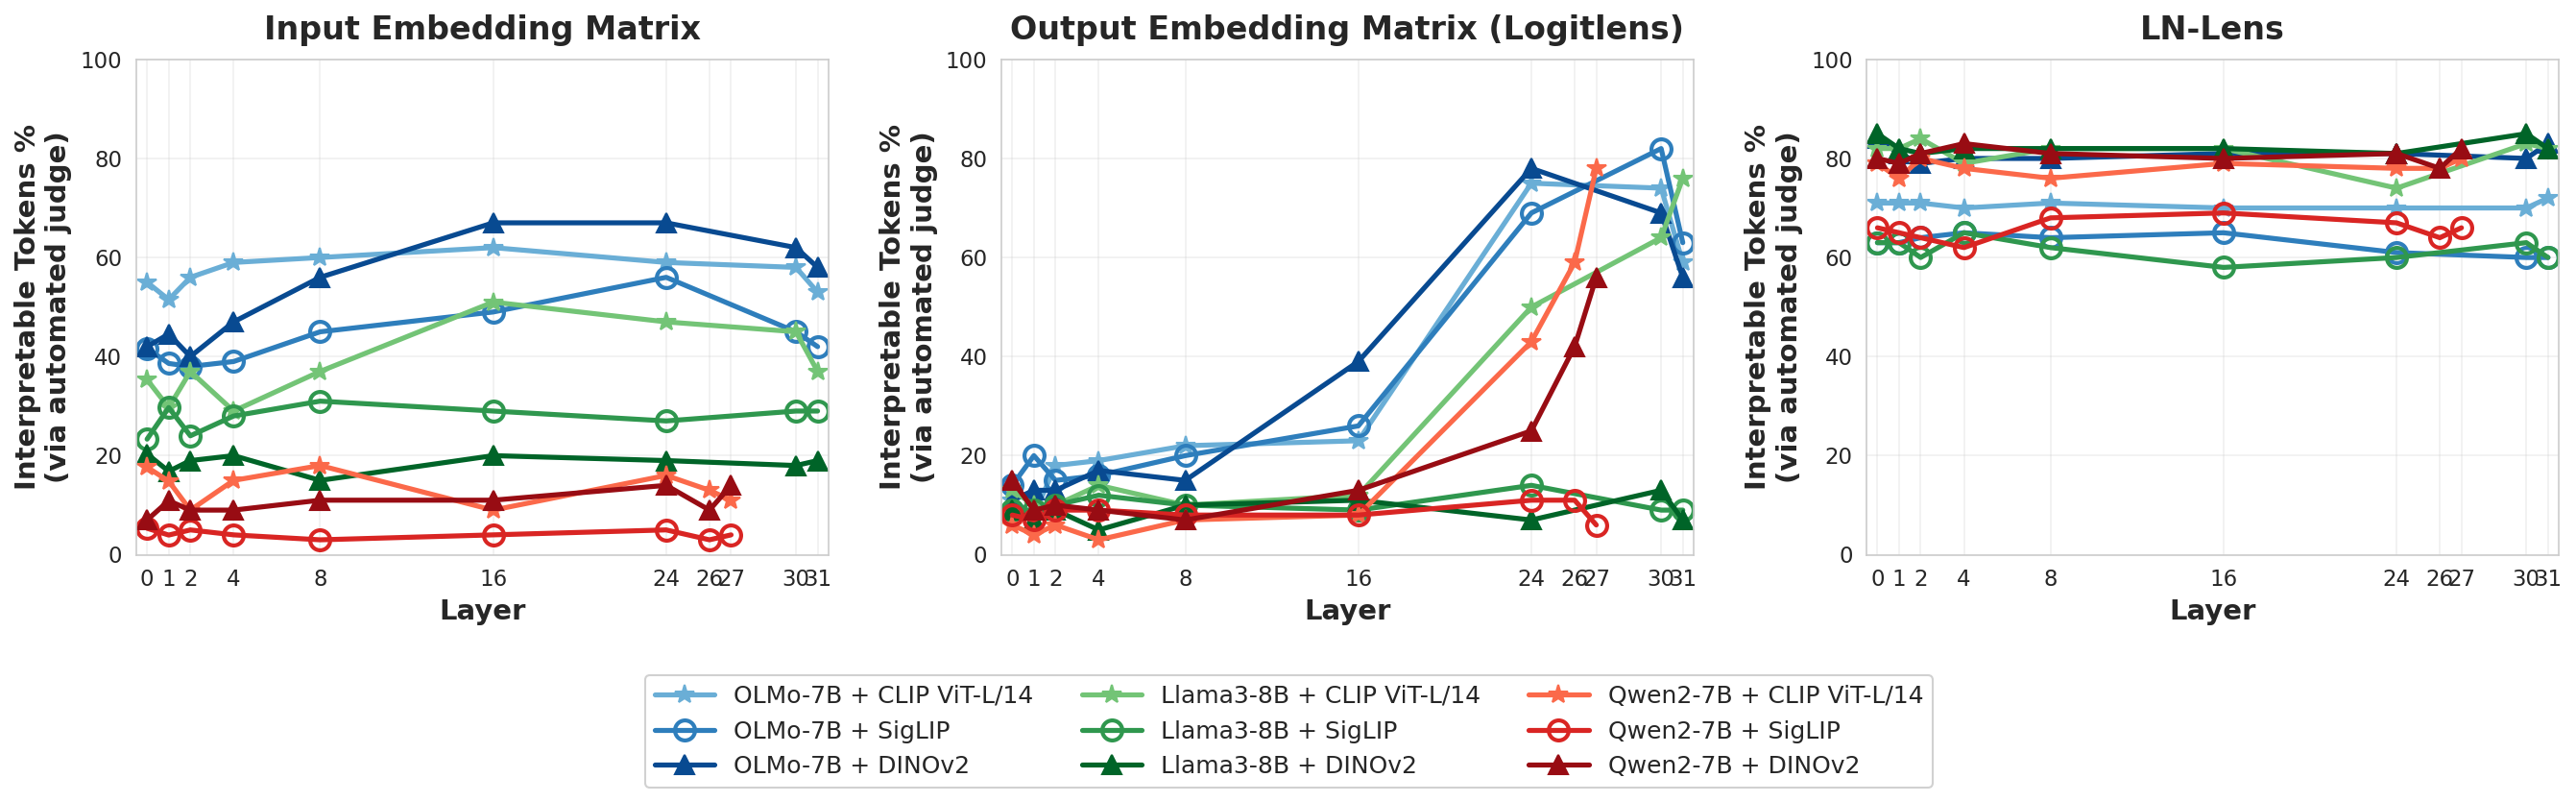

In [35]:
# Generate Figure 1: Unified interpretability plot
interp_output_dir = OUTPUT_DIR / 'interpretability'
interp_output_dir.mkdir(exist_ok=True)

fig1 = create_unified_lineplot(
    NN_DATA,
    LOGITLENS_DATA,
    CONTEXTUAL_DATA,
    output_path=interp_output_dir / 'fig1_unified_interpretability.pdf'
)


---
## Figure 2: Baselines Plot (NN + LogitLens)

Two-panel figure showing baseline methods.


In [36]:
def create_baselines_lineplot(nn_data, logitlens_data, output_path=None, figsize=(12, 14)):
    """
    Create a figure with 2 subplots stacked vertically for baselines (NN and LogitLens).
    Matches create_lineplot_unified.py create_baselines_lineplot()
    """
    color_map = get_color_map()

    # Filter data to expected layers
    nn_data = filter_to_expected_layers(nn_data)
    logitlens_data = filter_to_expected_layers(logitlens_data)
    all_expected_layers = get_all_expected_layers()

    # Vertical layout: 2 rows, 1 column
    fig, axes = plt.subplots(2, 1, figsize=figsize)

    subplot_configs = [
        {'ax': axes[0], 'data': nn_data, 'title': 'Input Embedding Matrix', 'xlabel': 'Layer'},
        {'ax': axes[1], 'data': logitlens_data, 'title': 'Output Embedding Matrix (Logitlens)', 'xlabel': 'Layer'},
    ]

    handles_dict = {}

    for config in subplot_configs:
        ax = config['ax']
        data = config['data']

        if not data:
            continue

        for llm in LLM_ORDER:
            for encoder in ENCODER_ORDER:
                key = f"{llm}+{encoder}"
                if key not in data:
                    continue

                layer_data = data[key]
                layers = sorted(layer_data.keys())
                values = [layer_data[l] for l in layers]

                if len(layers) == 0:
                    continue

                label = get_display_label(llm, encoder)
                marker = ENCODER_MARKERS.get(encoder, 'o')
                marker_facecolor = ENCODER_MARKER_FACECOLORS.get(encoder)
                color = color_map[(llm, encoder)]

                if marker_facecolor is not None:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   markerfacecolor=marker_facecolor,
                                   markeredgewidth=2, linewidth=2.5, markersize=10)
                else:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   linewidth=2.5, markersize=10)

                if label not in handles_dict:
                    handles_dict[label] = line

        ax.set_xlabel(config['xlabel'], fontsize=16, fontweight='bold')
        ax.set_ylabel('Interpretable Tokens %\n(via automated judge)', fontsize=14, fontweight='bold')
        ax.set_title(config['title'], fontsize=18, fontweight='bold', pad=15)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, 100)
        ax.tick_params(axis='both', labelsize=12)

        ax.set_xlim(min(all_expected_layers) - 0.5, max(all_expected_layers) + 0.5)
        ax.set_xticks(all_expected_layers)
        ax.set_xticklabels([str(t) for t in all_expected_layers])

    # Shared legend at the bottom for vertical layout
    ordered_handles = []
    ordered_labels = []
    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            label = get_display_label(llm, encoder)
            if label in handles_dict:
                ordered_handles.append(handles_dict[label])
                ordered_labels.append(label)

    fig.legend(ordered_handles, ordered_labels,
              loc='lower center', bbox_to_anchor=(0.5, -0.02),
              ncol=3, fontsize=13, framealpha=0.9,
              columnspacing=2.0, handlelength=2.5, handletextpad=1.0)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12, hspace=0.25)

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {output_path}")
        png_path = Path(output_path).with_suffix('.png')
        plt.savefig(png_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {png_path}")

    plt.show()
    return fig

Saved: paper_figures_output/interpretability/fig_baselines.pdf
Saved: paper_figures_output/interpretability/fig_baselines.png


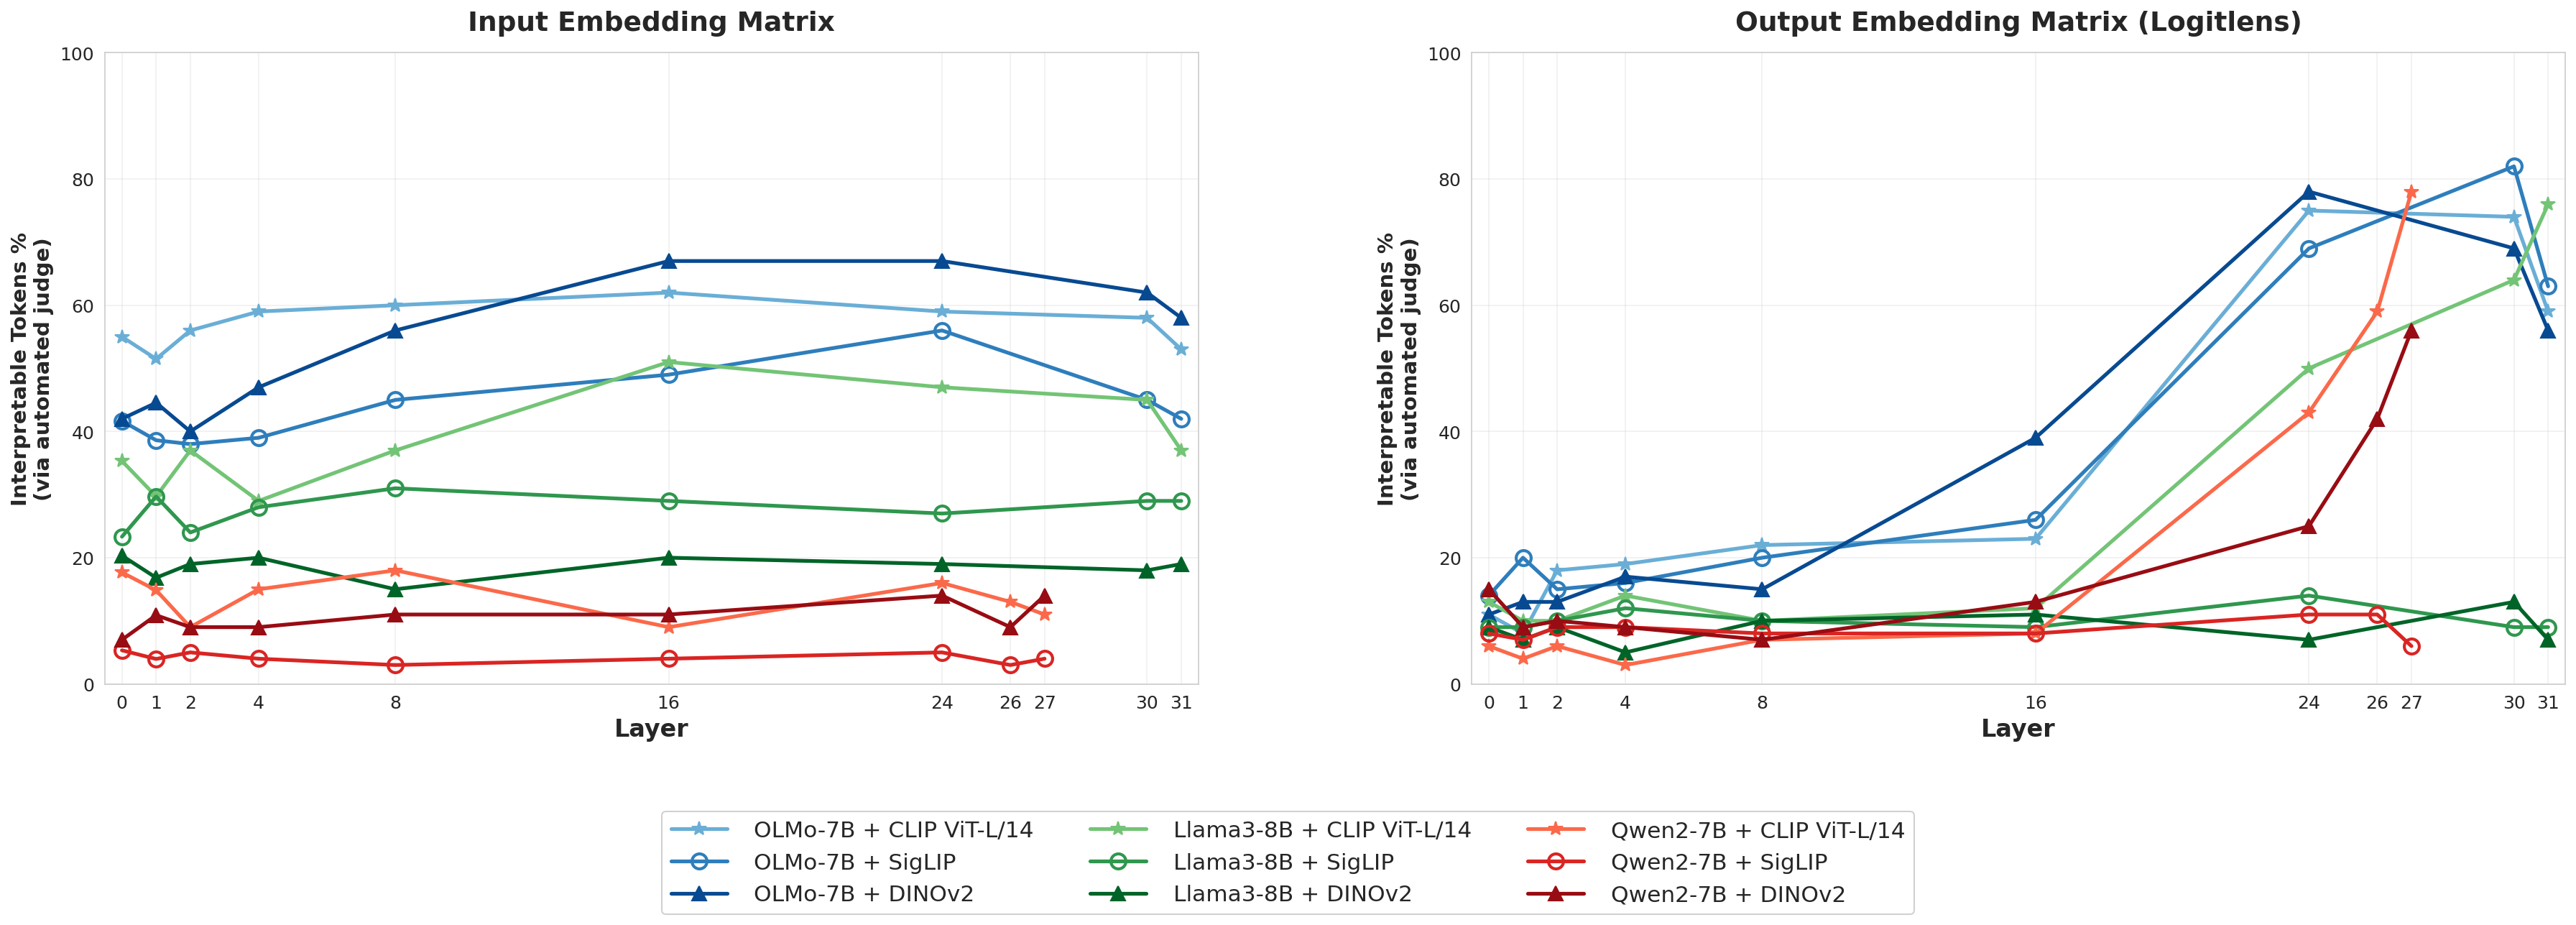

In [37]:
# Generate Figure 2: Baselines plot (NN + LogitLens)
fig_baselines = create_baselines_lineplot(
    NN_DATA,
    LOGITLENS_DATA,
    output_path=interp_output_dir / 'fig_baselines.pdf'
)


Single plot showing our LN-Lens method.



In [38]:
def create_lnlens_lineplot(contextual_data, output_path=None, figsize=(12, 8)):
    """
    Create a single figure for LN-Lens (our method).
    Matches create_lineplot_unified.py create_lnlens_lineplot()
    """
    color_map = get_color_map()

    # Filter to expected layers
    contextual_data = filter_to_expected_layers(contextual_data)
    all_expected_layers = get_all_expected_layers()

    fig, ax = plt.subplots(figsize=figsize)

    handles_dict = {}

    if contextual_data:
        for llm in LLM_ORDER:
            for encoder in ENCODER_ORDER:
                key = f"{llm}+{encoder}"
                if key not in contextual_data:
                    continue

                layer_data = contextual_data[key]
                layers = sorted(layer_data.keys())
                values = [layer_data[l] for l in layers]

                if len(layers) == 0:
                    continue

                label = get_display_label(llm, encoder)
                marker = ENCODER_MARKERS.get(encoder, 'o')
                marker_facecolor = ENCODER_MARKER_FACECOLORS.get(encoder)
                color = color_map[(llm, encoder)]

                if marker_facecolor is not None:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   markerfacecolor=marker_facecolor,
                                   markeredgewidth=2, linewidth=2.5, markersize=10)
                else:
                    line, = ax.plot(layers, values, marker=marker, color=color,
                                   linewidth=2.5, markersize=10)

                if label not in handles_dict:
                    handles_dict[label] = line

    ax.set_xlabel('Layer', fontsize=16, fontweight='bold')
    ax.set_ylabel('Interpretable Tokens %\n(via automated judge)', fontsize=14, fontweight='bold')
    ax.set_title('LN-Lens', fontsize=18, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 100)
    ax.tick_params(axis='both', labelsize=12)

    ax.set_xlim(min(all_expected_layers) - 0.5, max(all_expected_layers) + 0.5)
    ax.set_xticks(all_expected_layers)
    ax.set_xticklabels([str(t) for t in all_expected_layers])

    # Legend
    ordered_handles = []
    ordered_labels = []
    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            label = get_display_label(llm, encoder)
            if label in handles_dict:
                ordered_handles.append(handles_dict[label])
                ordered_labels.append(label)

    ax.legend(ordered_handles, ordered_labels,
              loc='lower right', ncol=1, fontsize=12, framealpha=0.9)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Saved: {output_path}")
        png_path = Path(output_path).with_suffix('.png')
        plt.savefig(png_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {png_path}")

    plt.show()
    return fig


Saved: paper_figures_output/interpretability/fig_lnlens.pdf
Saved: paper_figures_output/interpretability/fig_lnlens.png


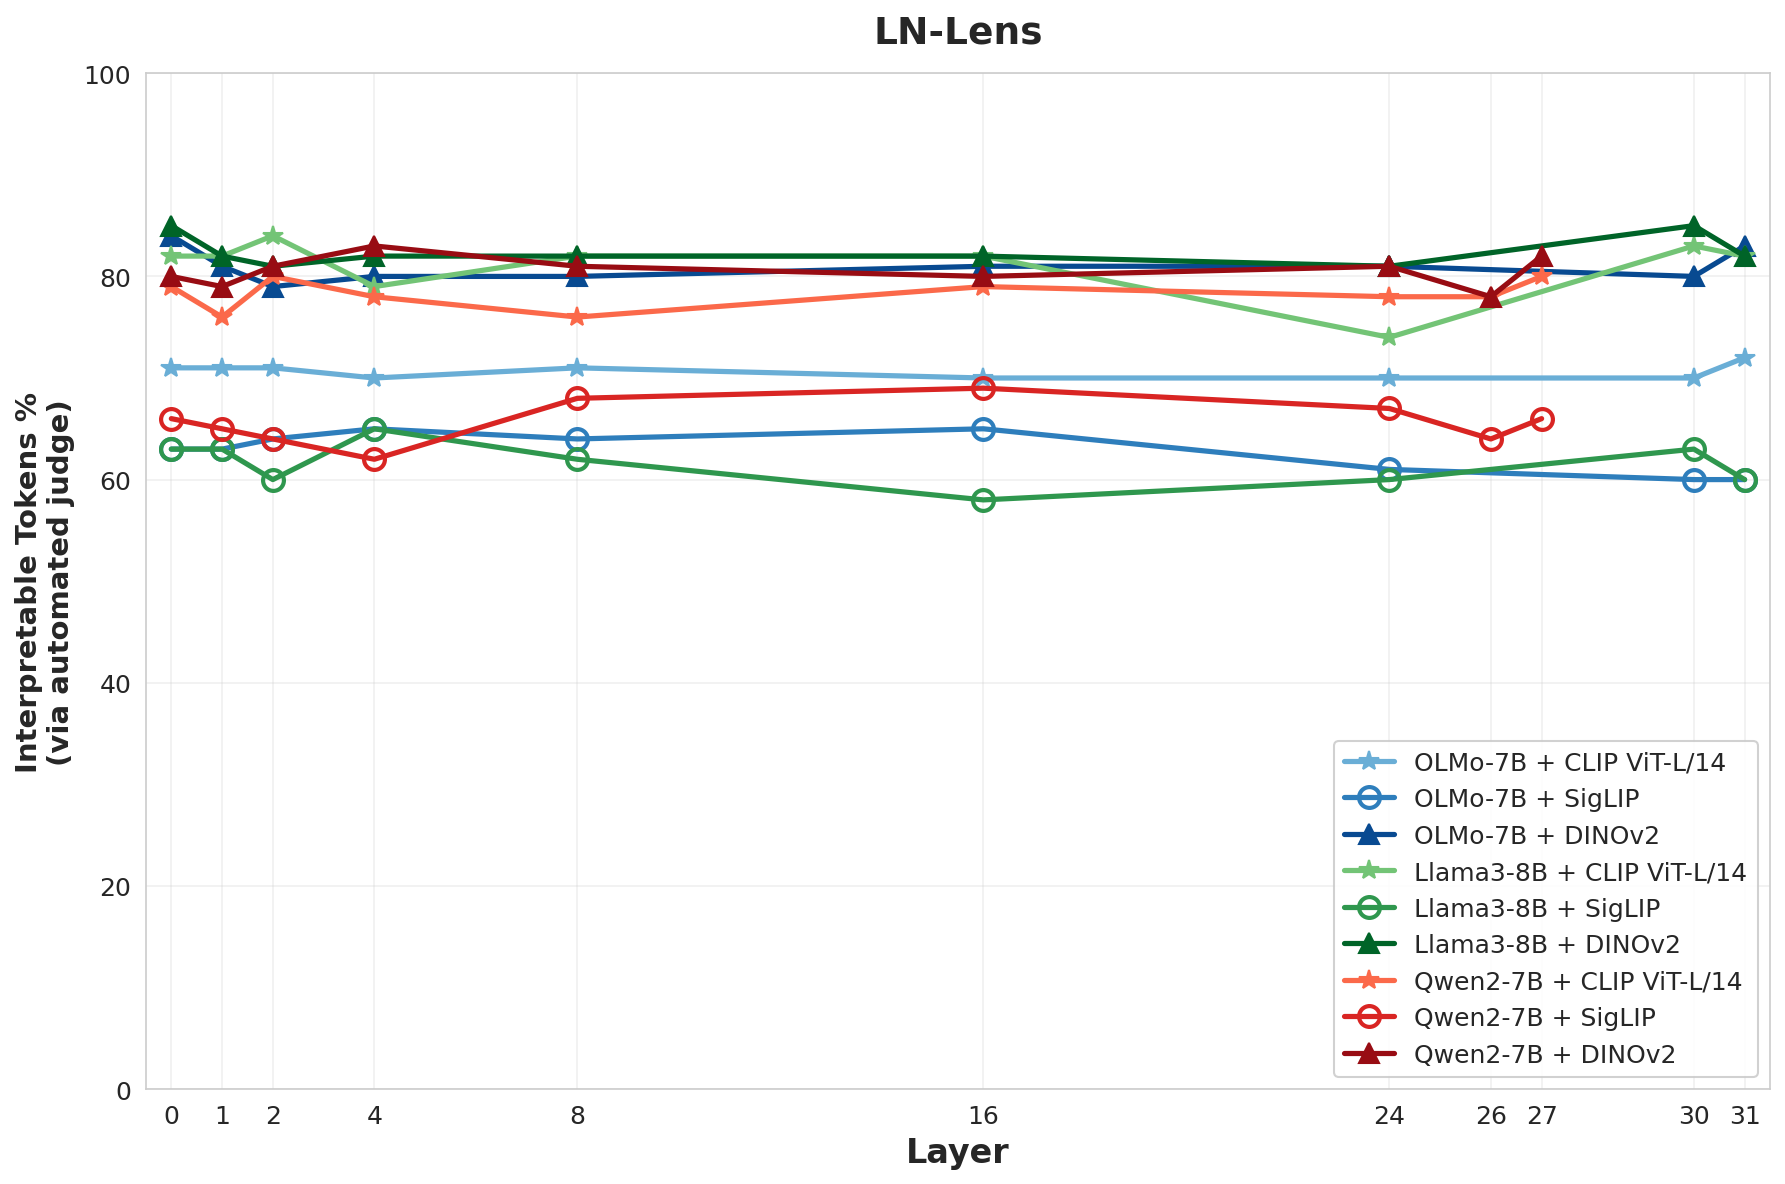

In [39]:
# Generate Figure 3: LN-Lens plot (our method)
fig_lnlens = create_lnlens_lineplot(
    CONTEXTUAL_DATA,
    output_path=interp_output_dir / 'fig_lnlens.pdf'
)


---
## Figure 4: Token Similarity Across Layers

3x3 grid showing how vision and text tokens evolve through LLM layers.
Y-axis: Cosine similarity to Layer 0 (input layer).


In [40]:
# Load token similarity data
if _data and 'token_similarity' in _data:
    TOKEN_SIM_DATA = _data['token_similarity']
    # Convert string keys to int
    for modality in ['vision', 'text']:
        TOKEN_SIM_DATA[modality] = {
            k: {int(layer): v for layer, v in layers.items()}
            for k, layers in TOKEN_SIM_DATA[modality].items()
        }
    print(f"✓ Loaded token similarity data: Vision {len(TOKEN_SIM_DATA['vision'])}, Text {len(TOKEN_SIM_DATA['text'])} models")
else:
    print("⚠ No token_similarity data in data.json")


✓ Loaded token similarity data: Vision 9, Text 9 models


In [41]:
def create_token_similarity_plot(token_sim_data, output_path=None, figsize=(16, 12)):
    """
    Create 3x3 token similarity plot.
    Matches create_token_similarity_plots.py create_combined_3x3_plot()
    """
    llm_order = ['olmo-7b', 'llama3-8b', 'qwen2-7b']
    enc_order = ['vit-l-14-336', 'siglip', 'dinov2-large-336']

    fig, axes = plt.subplots(3, 3, figsize=figsize)

    vision_data = token_sim_data['vision']
    text_data = token_sim_data['text']

    for row, llm in enumerate(llm_order):
        for col, encoder in enumerate(enc_order):
            ax = axes[row, col]
            key = f"{llm}+{encoder}"

            if key not in vision_data and key not in text_data:
                ax.set_visible(False)
                continue

            # Vision tokens
            if key in vision_data:
                vision_layers = sorted(vision_data[key].keys())
                vision_sim = [vision_data[key][l] for l in vision_layers]
                ax.plot(vision_layers, vision_sim, marker='o', linewidth=2.5, markersize=8,
                       label='Vision tokens', color='#2E86AB', alpha=0.8)

            # Text tokens
            if key in text_data:
                text_layers = sorted(text_data[key].keys())
                text_sim = [text_data[key][l] for l in text_layers]
                ax.plot(text_layers, text_sim, marker='s', linewidth=2.5, markersize=8,
                       label='Text tokens', color='#A23B72', alpha=0.8)

            # Title
            title = f'{LLM_DISPLAY_NAMES.get(llm, llm)} + {ENCODER_DISPLAY_NAMES.get(encoder, encoder)}'
            ax.set_title(title, fontsize=16, fontweight='bold', pad=10)

            # Labels (only on edges)
            if col == 0:
                ax.set_ylabel('Cosine Similarity\nto Layer 0', fontsize=15)
            if row == 2:
                ax.set_xlabel('LLM Layer', fontsize=15)

            # Styling
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.set_ylim(0, 1.05)
            ax.tick_params(labelsize=12)

    # Global legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.subplots_adjust(right=0.98, hspace=0.35, wspace=0.25, top=0.88, bottom=0.12)

    middle_subplot = axes[1, 1]
    bbox = middle_subplot.get_position()
    middle_col_center_x = bbox.x0 + bbox.width / 2

    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(middle_col_center_x, 0.02),
              ncol=2, fontsize=17, framealpha=0.9, columnspacing=2.0, handlelength=2.0)

    fig.suptitle('Same-Token Similarity Across LLM Layers', fontsize=20, fontweight='bold', y=0.95)

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.pdf'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")

    plt.show()
    return fig


✓ Saved: paper_figures_output/token_similarity_plots/token_similarity_combined_3x3.png


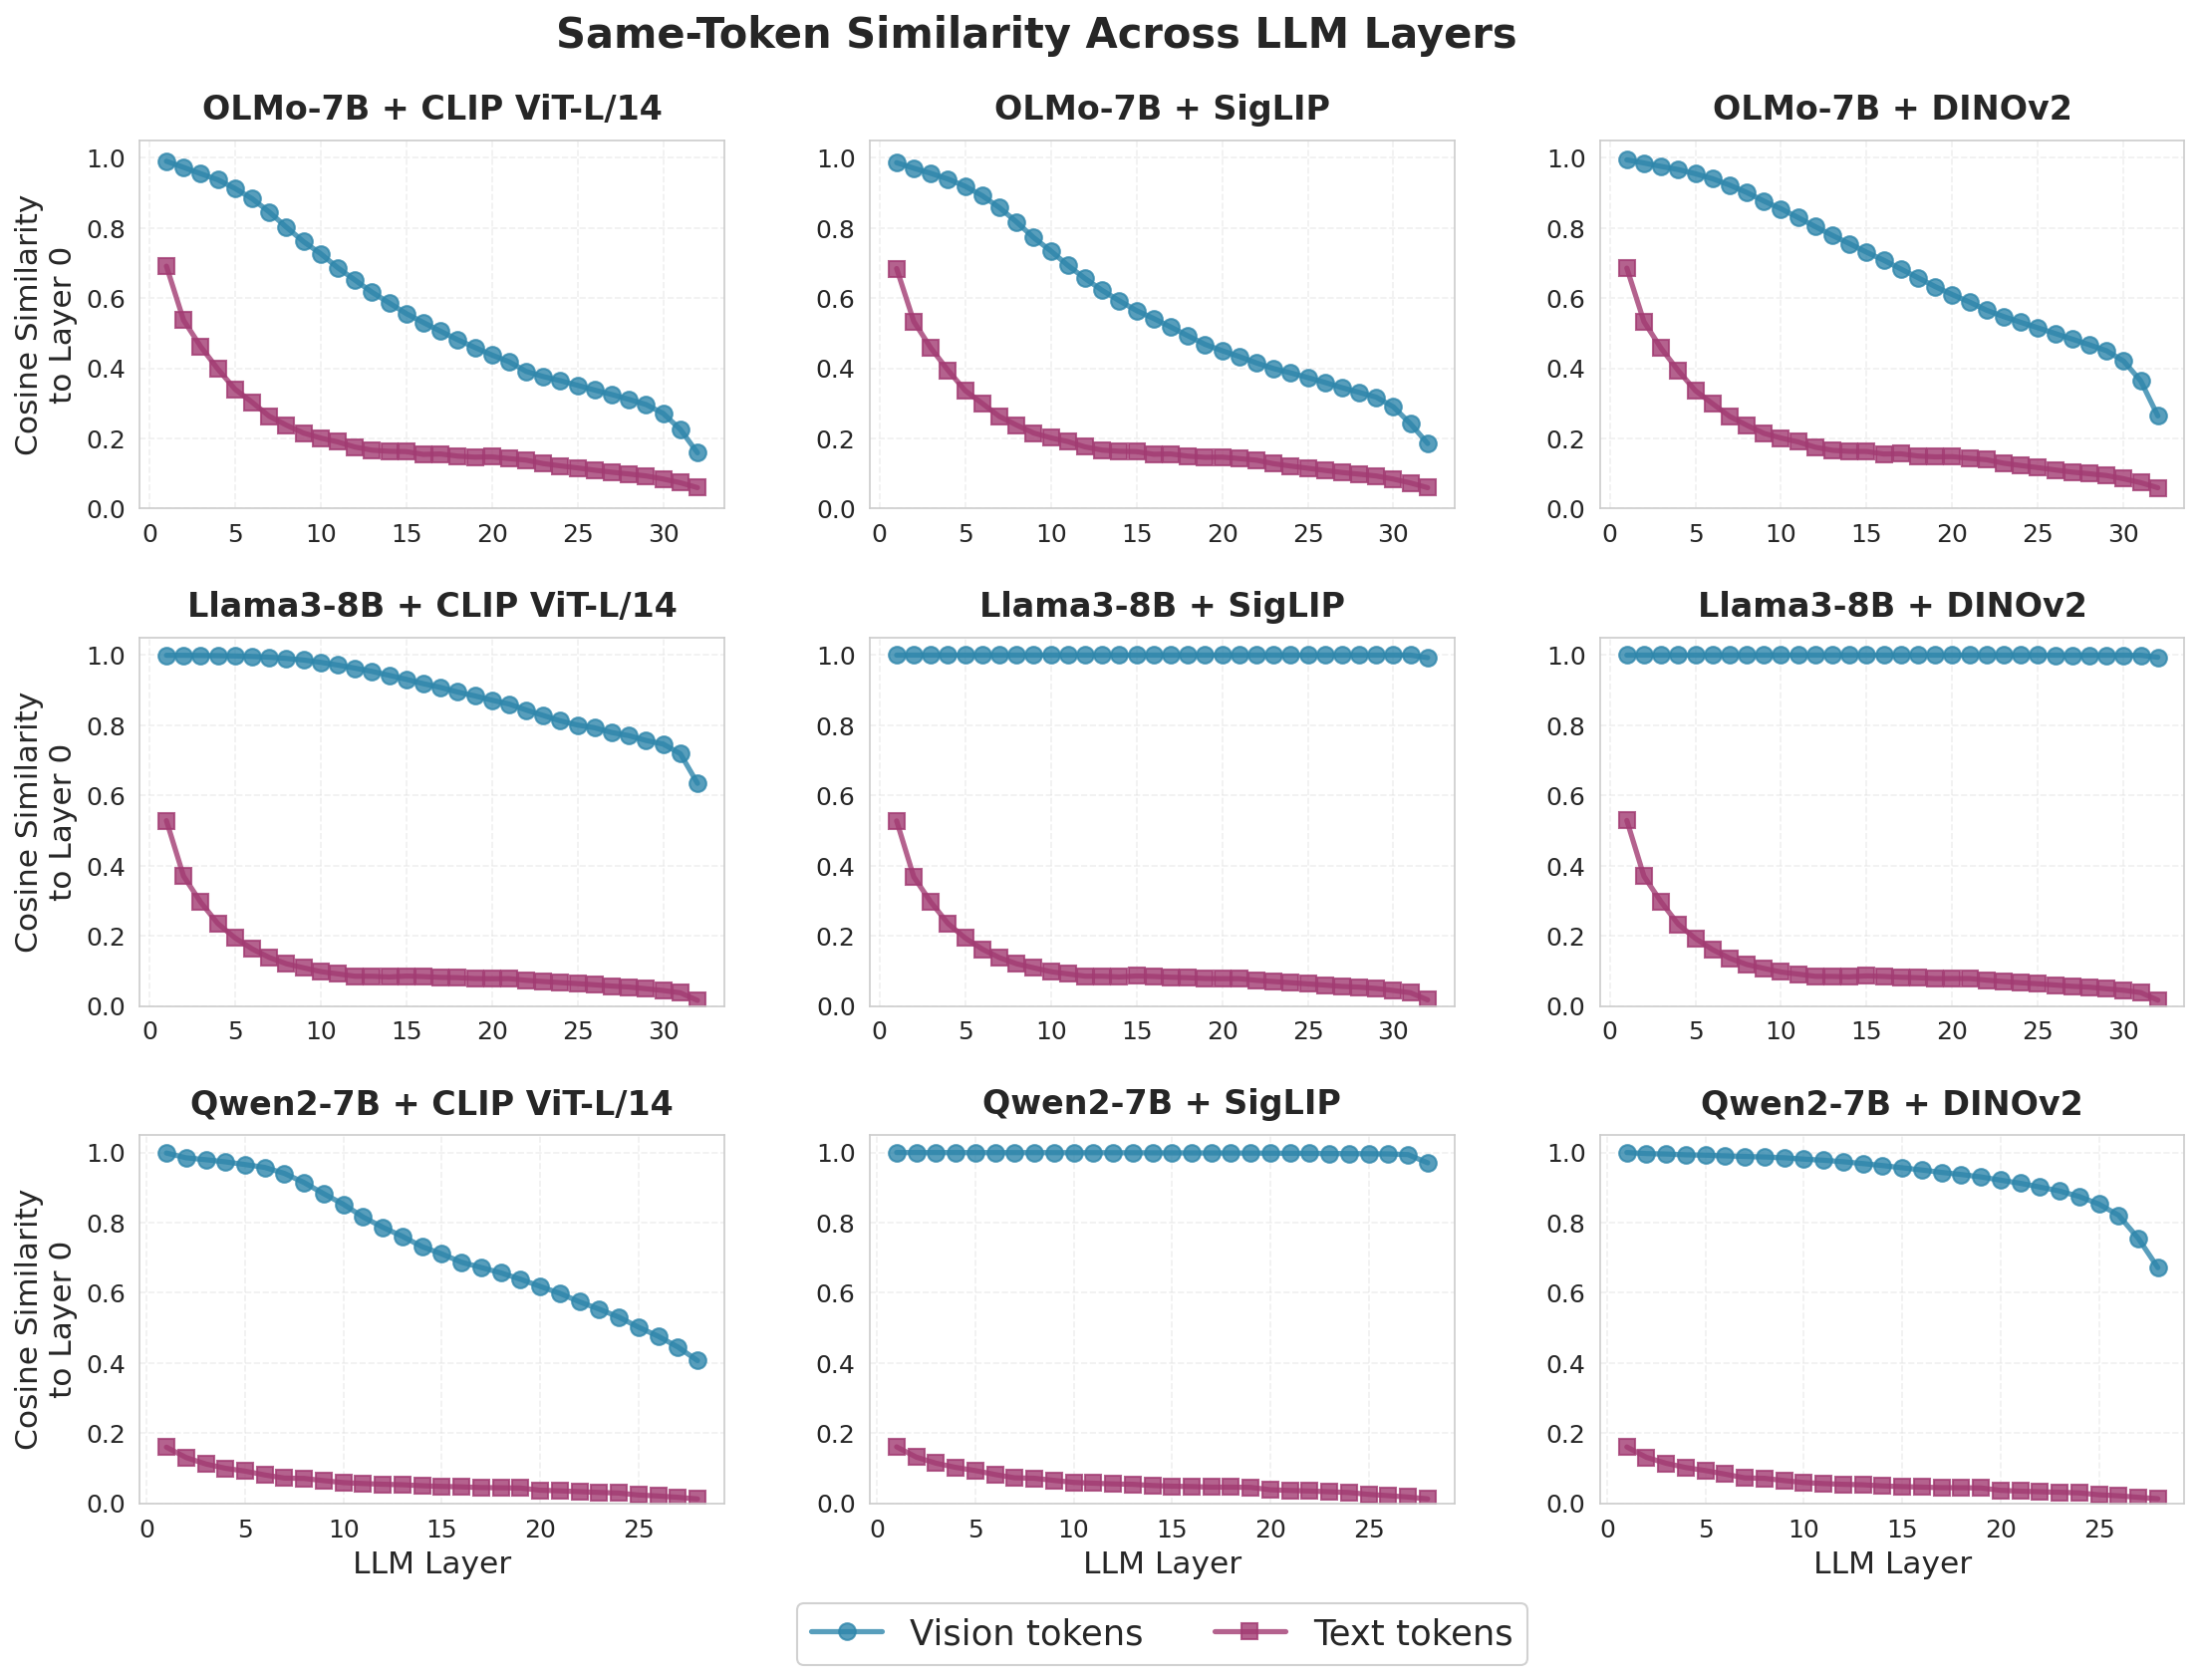

In [42]:
# Generate Figure 4: Token Similarity plot
token_sim_output_dir = OUTPUT_DIR / 'token_similarity_plots'
token_sim_output_dir.mkdir(exist_ok=True)

fig_token_sim = create_token_similarity_plot(
    TOKEN_SIM_DATA,
    output_path=token_sim_output_dir / 'token_similarity_combined_3x3.png'
)


---
## L2 Norm Distribution Analysis

3x6 grid showing L2 norm distributions of vision and text tokens across LLM layers.
- Each model gets two adjacent panels: Vision (left) and Text (right)
- Log x-axis scale to show the full range of L2 norms
- p99 marker (black dotted line) shows 99th percentile
- max marker (red dashed line) shows maximum value
- Color gradient from yellow (early layers) to red (late layers)

---
## Data Tables

Print the data in tabular format for reference.


In [43]:
def print_data_table(data, title):
    """Print data in a formatted table."""
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}")

    # Get all layers
    all_layers = set()
    for key, layer_data in data.items():
        all_layers.update(layer_data.keys())
    all_layers = sorted(list(all_layers))

    # Print header
    print(f"{'Model':<35}", end="")
    for layer in all_layers:
        print(f"{'L'+str(layer):>7}", end="")
    print()
    print("-" * (35 + len(all_layers) * 7))

    # Print data
    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            key = f"{llm}+{encoder}"
            if key not in data:
                continue
            label = get_display_label(llm, encoder)
            print(f"{label:<35}", end="")
            for layer in all_layers:
                value = data[key].get(layer)
                if value is not None:
                    print(f"{value:>6.1f}%", end="")
                else:
                    print(f"{'---':>7}", end="")
            print()

print_data_table(NN_DATA, "Static V-Lens (Nearest Neighbors) Data")
print_data_table(LOGITLENS_DATA, "Logit Lens Data")
print_data_table(CONTEXTUAL_DATA, "Contextual V-Lens Data")



Static V-Lens (Nearest Neighbors) Data
Model                                   L0     L1     L2     L4     L8    L16    L24    L26    L27    L30    L31
----------------------------------------------------------------------------------------------------------------
OLMo-7B + CLIP ViT-L/14              55.0%  51.5%  56.0%  59.0%  60.0%  62.0%  59.0%    ---    ---  58.0%  53.0%
OLMo-7B + SigLIP                     41.7%  38.6%  38.0%  39.0%  45.0%  49.0%  56.0%    ---    ---  45.0%  42.0%
OLMo-7B + DINOv2                     42.0%  44.5%  40.0%  47.0%  56.0%  67.0%  67.0%    ---    ---  62.0%  58.0%
Llama3-8B + CLIP ViT-L/14            35.3%  29.7%  37.0%  29.0%  37.0%  51.0%  47.0%    ---    ---  45.0%  37.0%
Llama3-8B + SigLIP                   23.3%  29.7%  24.0%  28.0%  31.0%  29.0%  27.0%    ---    ---  29.0%  29.0%
Llama3-8B + DINOv2                   20.3%  16.8%  19.0%  20.0%  15.0%  20.0%  19.0%    ---    ---  18.0%  19.0%
Qwen2-7B + CLIP ViT-L/14             17.7%  14.8%   9.0%

---
## Summary Statistics


In [44]:
def compute_summary_stats(data, name):
    """Compute summary statistics for a dataset."""
    print(f"\n{name}:")
    print("-" * 50)

    for llm in LLM_ORDER:
        for encoder in ENCODER_ORDER:
            key = f"{llm}+{encoder}"
            if key not in data:
                continue
            values = list(data[key].values())
            label = get_display_label(llm, encoder)
            print(f"  {label}:")
            print(f"    Layer 0: {data[key].get(0, 'N/A'):.1f}%" if 0 in data[key] else "    Layer 0: N/A")
            print(f"    Max: {max(values):.1f}% | Min: {min(values):.1f}% | Mean: {np.mean(values):.1f}%")

compute_summary_stats(NN_DATA, "Static V-Lens")
compute_summary_stats(LOGITLENS_DATA, "Logit Lens")
compute_summary_stats(CONTEXTUAL_DATA, "Contextual V-Lens")



Static V-Lens:
--------------------------------------------------
  OLMo-7B + CLIP ViT-L/14:
    Layer 0: 55.0%
    Max: 62.0% | Min: 51.5% | Mean: 57.1%
  OLMo-7B + SigLIP:
    Layer 0: 41.7%
    Max: 56.0% | Min: 38.0% | Mean: 43.8%
  OLMo-7B + DINOv2:
    Layer 0: 42.0%
    Max: 67.0% | Min: 40.0% | Mean: 53.7%
  Llama3-8B + CLIP ViT-L/14:
    Layer 0: 35.3%
    Max: 51.0% | Min: 29.0% | Mean: 38.7%
  Llama3-8B + SigLIP:
    Layer 0: 23.3%
    Max: 31.0% | Min: 23.3% | Mean: 27.8%
  Llama3-8B + DINOv2:
    Layer 0: 20.3%
    Max: 20.3% | Min: 15.0% | Mean: 18.6%
  Qwen2-7B + CLIP ViT-L/14:
    Layer 0: 17.7%
    Max: 18.0% | Min: 9.0% | Mean: 13.7%
  Qwen2-7B + SigLIP:
    Layer 0: 5.3%
    Max: 5.3% | Min: 3.0% | Mean: 4.1%
  Qwen2-7B + DINOv2:
    Layer 0: 7.0%
    Max: 14.0% | Min: 7.0% | Mean: 10.5%

Logit Lens:
--------------------------------------------------
  OLMo-7B + CLIP ViT-L/14:
    Layer 0: 11.0%
    Max: 75.0% | Min: 8.0% | Mean: 34.3%
  OLMo-7B + SigLIP:
    Layer 

---
## Key Findings

Summary of main observations from the data.


---
## Layer Alignment Heatmaps

Shows vision layer (Y) vs LLM layer (X) alignment as heatmaps.
Color intensity = normalized proportion of top-5 NNs from that LLM layer.


In [45]:
# Layer alignment heatmap configuration
LLM_DISPLAY_HEATMAP = {
    'olmo-7b': 'OLMo-7B',
    'llama3-8b': 'Llama3-8B',
    'qwen2-7b': 'Qwen2-7B'
}
ENC_DISPLAY_HEATMAP = {
    'vit-l-14-336': 'CLIP',
    'siglip': 'SigLIP',
    'dinov2-large-336': 'DINOv2'
}

# Fixed layer configurations per LLM (for consistent axes)
VISION_LAYERS_DEFAULT = [0, 1, 2, 4, 8, 16, 24, 30, 31]  # OLMo, Llama
VISION_LAYERS_QWEN = [0, 1, 2, 4, 8, 16, 24, 26, 27]     # Qwen

LLM_LAYERS_DEFAULT = [1, 2, 4, 8, 16, 24, 30, 31]  # OLMo, Llama (32 layers)
LLM_LAYERS_QWEN = [1, 2, 4, 8, 16, 24, 26, 27]     # Qwen (28 layers)

def get_fixed_layers(llm):
    """Get fixed vision and LLM layers based on LLM type."""
    if 'qwen' in llm.lower():
        return VISION_LAYERS_QWEN, LLM_LAYERS_QWEN
    else:
        return VISION_LAYERS_DEFAULT, LLM_LAYERS_DEFAULT


In [46]:
def create_single_heatmap(counts, llm, encoder, output_path=None):
    """Create a single heatmap for one model combination."""
    vision_layers, llm_layers = get_fixed_layers(llm)
    n_vision = len(vision_layers)
    n_llm = len(llm_layers)

    # Build the matrix: rows = vision layers (Y), cols = LLM layers (X)
    matrix = np.zeros((n_vision, n_llm))

    for i, vl in enumerate(vision_layers):
        vl_str = str(vl)
        layer_counts = counts.get(vl_str, {})
        total = sum(layer_counts.values())
        if total > 0:
            for j, ll in enumerate(llm_layers):
                ll_str = str(ll)
                matrix[i, j] = layer_counts.get(ll_str, 0) / total

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 5))

    # Heatmap with pcolormesh for cell borders
    # Fixed 0-1 color range for comparability
    im = ax.pcolormesh(matrix, cmap='viridis', vmin=0, vmax=1.0,
                       edgecolors='black', linewidth=0.5)
    ax.set_aspect('auto')

    # Labels
    ax.set_xlabel('LLM Layer', fontsize=18)
    ax.set_ylabel('Vision Layer', fontsize=18)
    ax.set_title(f'{LLM_DISPLAY_HEATMAP.get(llm, llm)} + {ENC_DISPLAY_HEATMAP.get(encoder, encoder)}',
                 fontsize=20, fontweight='bold', pad=15)

    # Y-axis: vision layers (ticks at cell centers: 0.5, 1.5, ...)
    ax.set_yticks([i + 0.5 for i in range(n_vision)])
    ax.set_yticklabels([str(vl) for vl in vision_layers], fontsize=15)

    # X-axis: LLM layers (ticks at cell centers)
    ax.set_xticks([i + 0.5 for i in range(n_llm)])
    ax.set_xticklabels([str(ll) for ll in llm_layers], fontsize=15)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Proportion of Top-5 NNs', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.pdf'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")

    plt.show()
    return fig


In [47]:
def create_combined_3x3_heatmap(all_counts, output_path=None):
    """Create combined 3x3 heatmap figure."""
    llm_order = ['olmo-7b', 'llama3-8b', 'qwen2-7b']
    enc_order = ['vit-l-14-336', 'siglip', 'dinov2-large-336']

    fig, axes = plt.subplots(3, 3, figsize=(14, 10))

    # Build matrices for all models
    all_matrices = {}

    for llm in llm_order:
        vision_layers, llm_layers = get_fixed_layers(llm)
        n_vision = len(vision_layers)
        n_llm = len(llm_layers)

        for encoder in enc_order:
            key = f"{llm}+{encoder}"
            counts = all_counts.get(key, {})
            if not counts:
                continue

            matrix = np.zeros((n_vision, n_llm))
            for i, vl in enumerate(vision_layers):
                vl_str = str(vl)
                layer_counts = counts.get(vl_str, {})
                total = sum(layer_counts.values())
                if total > 0:
                    for j, ll in enumerate(llm_layers):
                        ll_str = str(ll)
                        matrix[i, j] = layer_counts.get(ll_str, 0) / total

            all_matrices[key] = (matrix, vision_layers, llm_layers)

    images = []
    for row, llm in enumerate(llm_order):
        for col, encoder in enumerate(enc_order):
            ax = axes[row, col]
            key = f"{llm}+{encoder}"

            if key not in all_matrices:
                ax.set_visible(False)
                continue

            matrix, vision_layers, llm_layers = all_matrices[key]
            n_vision = len(vision_layers)
            n_llm = len(llm_layers)

            # Heatmap with pcolormesh for cell borders, fixed 0-1 color range
            im = ax.pcolormesh(matrix, cmap='viridis', vmin=0, vmax=1.0,
                              edgecolors='black', linewidth=0.3)
            ax.set_aspect('auto')
            images.append(im)

            # Title
            title = f'{LLM_DISPLAY_HEATMAP.get(llm, llm)} + {ENC_DISPLAY_HEATMAP.get(encoder, encoder)}'
            ax.set_title(title, fontsize=16, fontweight='bold', pad=10)

            # Y-axis labels (ticks at cell centers, only leftmost column shows labels)
            ax.set_yticks([i + 0.5 for i in range(n_vision)])
            if col == 0:
                ax.set_yticklabels([str(vl) for vl in vision_layers], fontsize=12)
                ax.set_ylabel('Vision Layer', fontsize=15)
            else:
                ax.set_yticklabels([])

            # X-axis labels - show on ALL subplots since LLM layers differ per model
            ax.set_xticks([i + 0.5 for i in range(n_llm)])
            ax.set_xticklabels([str(ll) for ll in llm_layers], fontsize=12)
            if row == 2:
                ax.set_xlabel('LLM Layer', fontsize=15)

    # Single colorbar for all
    # Adjust spacing: more vertical space, lower top to accommodate suptitle, more bottom space for x-labels
    fig.subplots_adjust(right=0.88, hspace=0.35, wspace=0.15, top=0.88, bottom=0.08)
    cbar_ax = fig.add_axes([0.90, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(images[0], cax=cbar_ax)
    cbar.set_label('Proportion of Top-5 NNs', fontsize=16)
    cbar.ax.tick_params(labelsize=15)

    fig.suptitle('Vision Token → LLM Layer Alignment', fontsize=20, fontweight='bold', y=0.95)

    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.pdf'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")

    plt.show()
    return fig


✓ Loaded layer alignment data for 9 model combinations
✓ Saved: paper_figures_output/layer_alignment_heatmaps/heatmap_combined_3x3.png


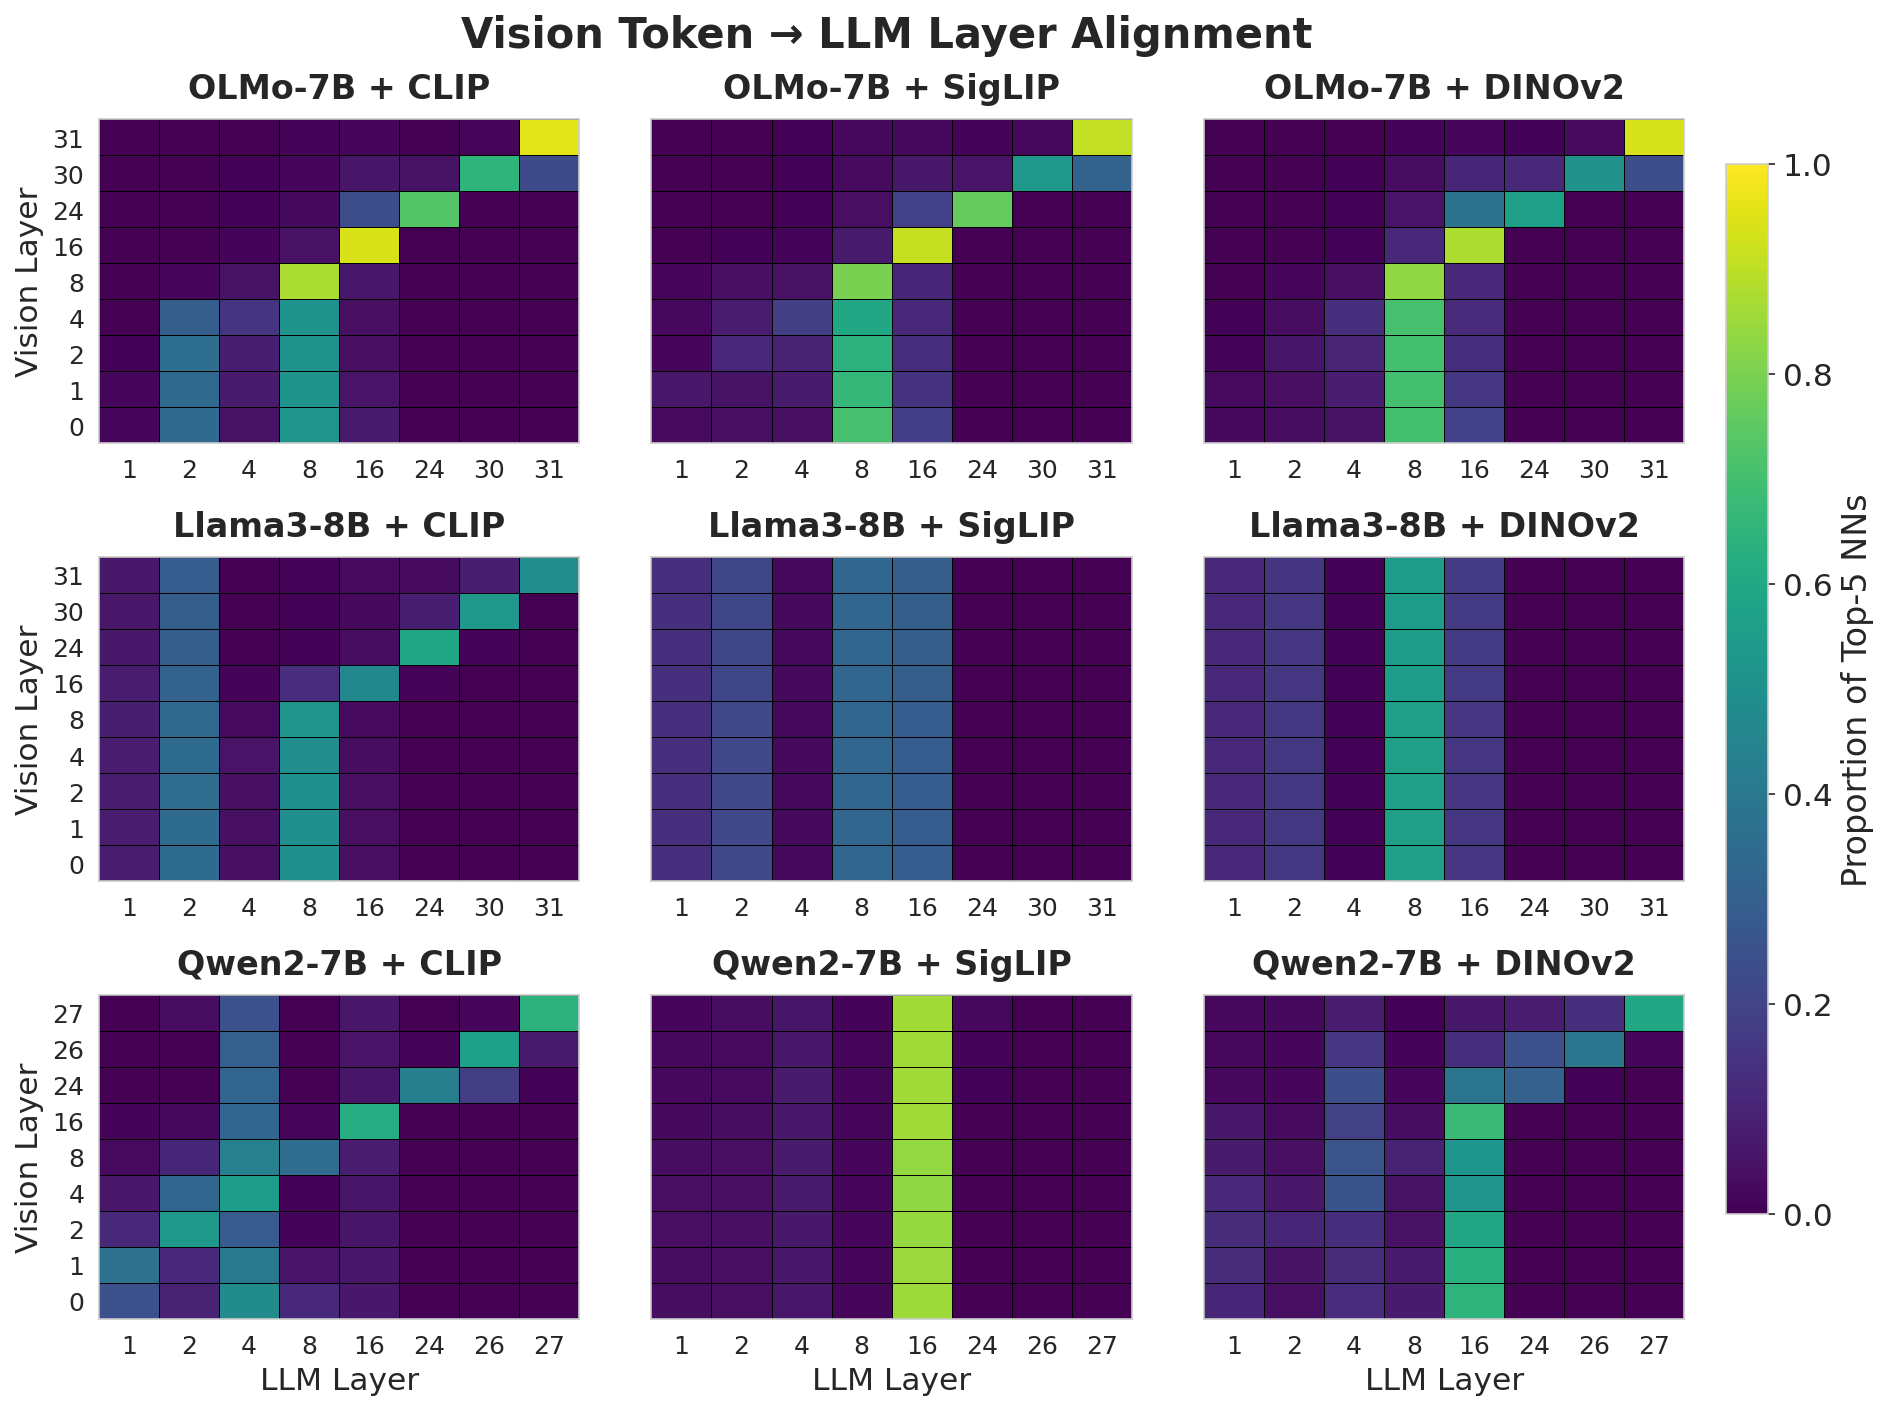

In [48]:
# Load layer alignment data
if _data and 'layer_alignment' in _data:
    LAYER_ALIGNMENT_DATA = _data['layer_alignment']
    print(f"✓ Loaded layer alignment data for {len(LAYER_ALIGNMENT_DATA)} model combinations")

    # Create combined 3x3 heatmap
    heatmap_output_dir = OUTPUT_DIR / 'layer_alignment_heatmaps'
    heatmap_output_dir.mkdir(exist_ok=True)
    combined_path = heatmap_output_dir / 'heatmap_combined_3x3.png'

    create_combined_3x3_heatmap(LAYER_ALIGNMENT_DATA, output_path=combined_path)
else:
    print("⚠ No layer_alignment data found in data.json")


---
## Similarity Histograms (Contextual V-Lens)

Shows the distribution of cosine similarities between vision tokens and their top-1 nearest neighbor contextual text embeddings. Histograms for visual layers 0, 8, and 16.


In [ ]:
# Similarity histogram plotting function
def create_combined_similarity_histogram(hist_data, visual_layer, output_path=None):
    """
    Create a combined 3x3 figure with similarity histograms for all 9 model combinations.
    hist_data: dict mapping model_key to {visual_layer: {counts, bin_edges, mean, ...}}
    """
    import matplotlib.gridspec as gridspec
    
    llm_order = ['olmo-7b', 'llama3-8b', 'qwen2-7b']
    enc_order = ['vit-l-14-336', 'siglip', 'dinov2-large-336']
    
    LLM_DISPLAY_SIM = {'olmo-7b': 'OLMo-7B', 'llama3-8b': 'Llama3-8B', 'qwen2-7b': 'Qwen2-7B'}
    ENC_DISPLAY_SIM = {'vit-l-14-336': 'CLIP ViT-L/14', 'siglip': 'SigLIP', 'dinov2-large-336': 'DINOv2'}
    
    fig = plt.figure(figsize=(14, 12))
    gs = gridspec.GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.25,
                           top=0.92, bottom=0.08, left=0.08, right=0.98)
    
    for row_idx, llm in enumerate(llm_order):
        for col_idx, encoder in enumerate(enc_order):
            key = f"{llm}+{encoder}"
            ax = fig.add_subplot(gs[row_idx, col_idx])
            
            title = f"{LLM_DISPLAY_SIM.get(llm, llm)} + {ENC_DISPLAY_SIM.get(encoder, encoder)}"
            
            # Get histogram data for this model and visual layer
            layer_key = str(visual_layer)  # JSON keys are strings
            if key in hist_data and layer_key in hist_data[key]:
                h = hist_data[key][layer_key]
                counts = h['counts']
                bin_edges = h['bin_edges']
                
                # Plot histogram bars
                bin_centers = [(bin_edges[i] + bin_edges[i+1]) / 2 for i in range(len(counts))]
                bin_width = bin_edges[1] - bin_edges[0]
                ax.bar(bin_centers, counts, width=bin_width * 0.9, 
                       edgecolor='black', linewidth=0.3, color='steelblue', alpha=0.8)
            
            ax.set_xlim(0, 1)
            ax.set_title(title, fontsize=16, fontweight='bold', pad=10)
            ax.grid(axis='y', alpha=0.3)
            
            # Labels only on edges
            if row_idx == 2:
                ax.set_xlabel('Cosine Similarity', fontsize=15)
            if col_idx == 0:
                ax.set_ylabel('Frequency', fontsize=15)
            
            ax.tick_params(axis='both', labelsize=12)
    
    fig.suptitle(f'Top-1 NN Cosine Similarity Distribution (Visual Layer {visual_layer})', 
                 fontsize=20, fontweight='bold')
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")
        pdf_path = Path(output_path).with_suffix('.pdf')
        plt.savefig(pdf_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close(fig)
    return fig


In [ ]:
# Generate similarity histograms for layers 0, 8, 16
if _data and 'similarity_histograms' in _data:
    SIMILARITY_HIST_DATA = _data['similarity_histograms']
    print(f"✓ Loaded similarity histogram data for {len(SIMILARITY_HIST_DATA)} model combinations")
    
    sim_hist_output_dir = OUTPUT_DIR / 'similarity_histograms'
    sim_hist_output_dir.mkdir(exist_ok=True)
    
    for visual_layer in [0, 8, 16]:
        output_path = sim_hist_output_dir / f'similarity_hist_combined_3x3_visual{visual_layer}.png'
        create_combined_similarity_histogram(SIMILARITY_HIST_DATA, visual_layer, output_path=output_path)
else:
    print("⚠ No similarity_histograms data found in data.json")


---
## Layer Evolution Analysis

Analysis of how vision token interpretations evolve across layers:
- **Interpretation Types**: Concrete vs Abstract vs Global interpretations
- **Visual Attributes**: Color, Shape, Texture word frequency
- **POS Tags**: Part-of-speech distribution across layers
- **Concreteness**: Average word concreteness ratings

Pre-generated plots are in `paper_figures_output/layer_evolution/`


In [ ]:
# Load layer evolution data
if _data and 'layer_evolution' in _data:
    LAYER_EVOLUTION_DATA = _data['layer_evolution']
    print(f"✓ Loaded layer evolution data:")
    print(f"  - interpretation_types: {len(LAYER_EVOLUTION_DATA.get('interpretation_types', {}))} models")
    print(f"  - visual_attributes: {len(LAYER_EVOLUTION_DATA.get('visual_attributes', {}))} models")
    print(f"  - pos_tags: {len(LAYER_EVOLUTION_DATA.get('pos_tags', {}))} models")
else:
    print("⚠ No layer_evolution data found in data.json")


In [ ]:
# Display pre-generated layer evolution plots
from IPython.display import Image, display
from pathlib import Path

layer_evo_dir = OUTPUT_DIR / 'layer_evolution'
if layer_evo_dir.exists():
    plot_files = [
        ('interpretation_types_combined.png', 'Interpretation Types (Concrete/Abstract/Global)'),
        ('visual_attributes_combined.png', 'Visual Attributes (Color/Shape/Texture)'),
        ('pos_tags_combined.png', 'POS Tags Distribution'),
        ('concreteness_combined.png', 'Word Concreteness Ratings'),
    ]
    
    for filename, title in plot_files:
        filepath = layer_evo_dir / filename
        if filepath.exists():
            print(f"\n{title}")
            print("=" * 60)
            display(Image(filename=str(filepath), width=900))
        else:
            print(f"⚠ {filename} not found")
else:
    print(f"⚠ Layer evolution directory not found: {layer_evo_dir}")


In [ ]:
# Print layer evolution data tables
def print_layer_evolution_table(data, data_type, title):
    """Print layer evolution data in tabular format."""
    print(f"\n{'='*80}")
    print(f"{title}")
    print(f"{'='*80}")
    
    if data_type not in data:
        print("No data available")
        return
    
    type_data = data[data_type]
    
    # Get all layers across all models
    all_layers = set()
    for model_data in type_data.values():
        all_layers.update(model_data.keys())
    all_layers = sorted([int(l) for l in all_layers])
    
    # Get metrics from first model's first layer
    sample_model = next(iter(type_data.values()))
    sample_layer = next(iter(sample_model.values()))
    metrics = list(sample_layer.keys())
    
    for metric in metrics:
        print(f"\n{metric.upper()}")
        print(f"{'Model':<35}", end="")
        for layer in all_layers:
            print(f"{'L'+str(layer):>7}", end="")
        print()
        print("-" * (35 + len(all_layers) * 7))
        
        for llm in LLM_ORDER:
            for encoder in ENCODER_ORDER:
                key = f"{llm}+{encoder}"
                if key not in type_data:
                    continue
                label = get_display_label(llm, encoder)
                print(f"{label:<35}", end="")
                for layer in all_layers:
                    value = type_data[key].get(str(layer), {}).get(metric)
                    if value is not None:
                        print(f"{value:>6.1f}%", end="")
                    else:
                        print(f"{'---':>7}", end="")
                print()

if 'LAYER_EVOLUTION_DATA' in dir():
    print_layer_evolution_table(LAYER_EVOLUTION_DATA, 'interpretation_types', 'Interpretation Types (%)')
    print_layer_evolution_table(LAYER_EVOLUTION_DATA, 'visual_attributes', 'Visual Attributes (%)')


---
## Qwen2-VL (Off-the-shelf Model)

Comparison with Qwen2-VL-7B-Instruct, an off-the-shelf vision-language model that was NOT trained with our setup. This provides a baseline for how well our connector-only training approach performs compared to full VLM training.

In [ ]:
# =============================================================================
# L2 NORM DATA LOADING
# =============================================================================
import json
from pathlib import Path

# Model configurations
L2NORM_LLMS = ['olmo-7b', 'llama3-8b', 'qwen2-7b']
L2NORM_ENCODERS = ['vit-l-14-336', 'dinov2-large-336', 'siglip']

L2NORM_LLM_DISPLAY = {'olmo-7b': 'OLMo-7B', 'llama3-8b': 'Llama3-8B', 'qwen2-7b': 'Qwen2-7B'}
L2NORM_ENC_DISPLAY = {'vit-l-14-336': 'CLIP', 'dinov2-large-336': 'DINOv2', 'siglip': 'SigLIP'}

# Layers per LLM
L2NORM_LAYERS_32 = [0, 4, 8, 16, 24, 31]  # OLMo, Llama
L2NORM_LAYERS_28 = [0, 4, 8, 16, 24, 27]  # Qwen

def get_l2norm_ckpt_name(llm, enc):
    """Get checkpoint name for L2 norm data."""
    if llm == "qwen2-7b" and enc == "vit-l-14-336":
        return f"train_mlp-only_pixmo_cap_resize_{llm}_{enc}_seed10_step12000-unsharded"
    return f"train_mlp-only_pixmo_cap_resize_{llm}_{enc}_step12000-unsharded"

def load_l2norm_raw_data(base_path, ckpt_name, modality):
    """Load raw L2 norm values from JSON file."""
    if modality == 'vision':
        raw_file = base_path / ckpt_name / "l2norm_raw_values.json"
    else:
        raw_file = base_path / ckpt_name / "text_l2norm_raw_values.json"
    
    if not raw_file.exists():
        return None
    
    with open(raw_file) as f:
        data = json.load(f)
    return {int(k): np.array(v) for k, v in data['raw_norms'].items()}

# Load L2 norm data
L2NORM_BASE_VISION = Path("../analysis_results/sameToken_acrossLayers_l2norm")
L2NORM_BASE_TEXT = Path("../analysis_results/sameToken_acrossLayers_text_l2norm")

L2NORM_VISION_DATA = {}
L2NORM_TEXT_DATA = {}

for llm in L2NORM_LLMS:
    for enc in L2NORM_ENCODERS:
        key = f"{llm}+{enc}"
        ckpt_name = get_l2norm_ckpt_name(llm, enc)
        
        vision_data = load_l2norm_raw_data(L2NORM_BASE_VISION, ckpt_name, 'vision')
        text_data = load_l2norm_raw_data(L2NORM_BASE_TEXT, ckpt_name, 'text')
        
        if vision_data:
            L2NORM_VISION_DATA[key] = vision_data
        if text_data:
            L2NORM_TEXT_DATA[key] = text_data

print(f"✓ Loaded L2 norm data:")
print(f"  Vision: {len(L2NORM_VISION_DATA)} models")
print(f"  Text: {len(L2NORM_TEXT_DATA)} models")

In [ ]:
def create_l2norm_3x6_grid(vision_data, text_data, output_path=None, use_log_scale=True):
    """
    Create 3x6 L2 norm distribution grid with Vision|Text side-by-side.
    
    Args:
        vision_data: Dict mapping model_key to {layer: np.array of L2 norms}
        text_data: Dict mapping model_key to {layer: np.array of L2 norms}
        output_path: Path to save figure
        use_log_scale: If True, use logarithmic x-axis
    """
    cmap = plt.cm.YlOrRd
    
    def get_colors(layers):
        return {layer: cmap(0.2 + 0.7 * i / (len(layers) - 1)) for i, layer in enumerate(layers)}
    
    # Create 3x6 figure: 3 LLMs × 6 panels (Vision|Text for each encoder)
    fig = plt.figure(figsize=(24, 18), dpi=150)
    
    for row, llm in enumerate(L2NORM_LLMS):
        for col, enc in enumerate(L2NORM_ENCODERS):
            key = f"{llm}+{enc}"
            
            vision_raw = vision_data.get(key)
            text_raw = text_data.get(key)
            
            layers = L2NORM_LAYERS_28 if llm == 'qwen2-7b' else L2NORM_LAYERS_32
            colors = get_colors(layers)
            
            # Two subplots per cell: Vision (left) and Text (right)
            ax_v = fig.add_subplot(3, 6, row * 6 + col * 2 + 1)
            ax_t = fig.add_subplot(3, 6, row * 6 + col * 2 + 2)
            
            # Vision subplot
            if vision_raw:
                all_vision = np.concatenate([vision_raw[l] for l in layers if l in vision_raw])
                v_max = all_vision.max() * 1.02
                v_min = max(1, all_vision.min() * 0.98) if use_log_scale else 0
                bins_v = np.logspace(np.log10(v_min), np.log10(v_max), 61) if use_log_scale else np.linspace(0, v_max, 61)
                
                for layer in layers:
                    if layer in vision_raw:
                        data = vision_raw[layer]
                        ax_v.hist(data, bins=bins_v, alpha=0.5, color=colors[layer],
                                  label=f'L{layer}', density=True)
                
                # Add p99 and max markers
                p99 = np.percentile(all_vision, 99)
                v_max_val = np.max(all_vision)
                ylim = ax_v.get_ylim()
                
                # p99 marker (black dotted)
                ax_v.axvline(p99, color='black', linestyle=':', linewidth=1.5, alpha=0.8)
                ax_v.annotate('p99', xy=(p99, ylim[1]*0.85), xytext=(p99*0.7, ylim[1]*0.95),
                              fontsize=8, ha='center', color='black',
                              arrowprops=dict(arrowstyle='->', color='black', lw=1))
                
                # max marker (red dashed)
                ax_v.axvline(v_max_val, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
                ax_v.annotate('max', xy=(v_max_val, ylim[1]*0.7), xytext=(v_max_val*1.1, ylim[1]*0.85),
                              fontsize=8, ha='center', color='red',
                              arrowprops=dict(arrowstyle='->', color='red', lw=1))
            
            if use_log_scale:
                ax_v.set_xscale('log')
            ax_v.set_title(f'{L2NORM_LLM_DISPLAY[llm]}+{L2NORM_ENC_DISPLAY[enc]}\nVision', fontsize=11, fontweight='bold')
            ax_v.set_xlabel('L2 Norm', fontsize=9)
            ax_v.set_ylabel('Density', fontsize=9)
            ax_v.tick_params(labelsize=8)
            ax_v.grid(True, alpha=0.3, axis='y')
            if row == 0 and col == 0:
                ax_v.legend(fontsize=7, loc='upper right')
            
            # Text subplot
            if text_raw:
                all_text = np.concatenate([text_raw[l] for l in layers if l in text_raw])
                t_max = all_text.max() * 1.02
                t_min = max(1, all_text.min() * 0.98) if use_log_scale else 0
                bins_t = np.logspace(np.log10(t_min), np.log10(t_max), 61) if use_log_scale else np.linspace(0, t_max, 61)
                
                for layer in layers:
                    if layer in text_raw:
                        data = text_raw[layer]
                        ax_t.hist(data, bins=bins_t, alpha=0.5, color=colors[layer],
                                  label=f'L{layer}', density=True)
                
                # Add p99 and max markers
                p99 = np.percentile(all_text, 99)
                t_max_val = np.max(all_text)
                ylim = ax_t.get_ylim()
                
                # p99 marker (black dotted)
                ax_t.axvline(p99, color='black', linestyle=':', linewidth=1.5, alpha=0.8)
                ax_t.annotate('p99', xy=(p99, ylim[1]*0.85), xytext=(p99*0.7, ylim[1]*0.95),
                              fontsize=8, ha='center', color='black',
                              arrowprops=dict(arrowstyle='->', color='black', lw=1))
                
                # max marker (red dashed)
                ax_t.axvline(t_max_val, color='red', linestyle='--', linewidth=1.5, alpha=0.8)
                ax_t.annotate('max', xy=(t_max_val, ylim[1]*0.7), xytext=(t_max_val*1.1, ylim[1]*0.85),
                              fontsize=8, ha='center', color='red',
                              arrowprops=dict(arrowstyle='->', color='red', lw=1))
            
            if use_log_scale:
                ax_t.set_xscale('log')
            ax_t.set_title('Text', fontsize=11, fontweight='bold')
            ax_t.set_xlabel('L2 Norm', fontsize=9)
            ax_t.tick_params(labelsize=8)
            ax_t.grid(True, alpha=0.3, axis='y')
    
    scale_label = " (Log Scale)" if use_log_scale else ""
    fig.suptitle(f'L2 Norm Distribution Across LLM Layers{scale_label}', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.pdf'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")
    
    plt.show()
    return fig

In [ ]:
# Generate L2 Norm Distribution Plot (3x6 grid with log scale)
l2norm_output_dir = OUTPUT_DIR / 'l2norm_plots'
l2norm_output_dir.mkdir(exist_ok=True)

if L2NORM_VISION_DATA and L2NORM_TEXT_DATA:
    fig_l2norm = create_l2norm_3x6_grid(
        L2NORM_VISION_DATA, L2NORM_TEXT_DATA,
        output_path=l2norm_output_dir / 'l2norm_3x3_grid_log.png',
        use_log_scale=True
    )
else:
    print("⚠ L2 norm data not available. Run the analysis scripts first:")

---
## Max L2 Norm Token Embedding Analysis

3x3 grid showing the distribution of individual embedding dimension values for the vision token with maximum L2 norm in each model.

**Key question**: Are high L2 norms driven by a few large values (sparse outliers) or uniformly larger values across all dimensions?

**Finding**: Llama3-8B and Qwen2-7B have ~100x larger embedding scales than OLMo-7B across ALL dimensions (std ~1700-11000 vs ~10-20), indicating uniform scaling rather than sparse outliers.

In [ ]:
# =============================================================================
# MAX TOKEN EMBEDDING DATA LOADING
# =============================================================================

MAX_TOKEN_BASE = Path("../analysis_results/max_token_embeddings")

def load_max_token_data(base_path, llm, enc):
    """Load max token embedding data from JSON file."""
    ckpt_name = get_l2norm_ckpt_name(llm, enc)
    json_file = base_path / f"{ckpt_name}_max_token.json"
    
    if not json_file.exists():
        return None
    
    with open(json_file) as f:
        return json.load(f)

# Load max token embedding data
MAX_TOKEN_DATA = {}

for llm in L2NORM_LLMS:
    for enc in L2NORM_ENCODERS:
        key = f"{llm}+{enc}"
        data = load_max_token_data(MAX_TOKEN_BASE, llm, enc)
        if data:
            MAX_TOKEN_DATA[key] = data

print(f"✓ Loaded max token embedding data for {len(MAX_TOKEN_DATA)} models")
if MAX_TOKEN_DATA:
    # Print summary
    print("\nMax L2 Norm Summary:")
    print(f"{'Model':<35} {'L2 Norm':>12} {'Layer':>7} {'Std':>12}")
    print("-" * 70)
    for key, data in MAX_TOKEN_DATA.items():
        emb = np.array(data['max_embedding_values'])
        print(f"{key:<35} {data['max_info']['l2_norm']:>12.1f} {data['max_info']['layer']:>7} {emb.std():>12.2f}")

In [ ]:
def create_max_token_embedding_plot(max_token_data, output_path=None):
    """
    Create 3x3 grid showing distribution of embedding dimension values for max L2 norm tokens.
    
    Args:
        max_token_data: Dict mapping model_key to JSON data with 'max_embedding_values'
        output_path: Path to save figure
    """
    fig, axes = plt.subplots(3, 3, figsize=(16, 14), dpi=150)
    
    for row, llm in enumerate(L2NORM_LLMS):
        for col, enc in enumerate(L2NORM_ENCODERS):
            ax = axes[row, col]
            key = f"{llm}+{enc}"
            
            if key not in max_token_data:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', fontsize=14)
                ax.set_title(f'{L2NORM_LLM_DISPLAY[llm]} + {L2NORM_ENC_DISPLAY[enc]}',
                            fontsize=12, fontweight='bold')
                continue
            
            data = max_token_data[key]
            embedding = np.array(data['max_embedding_values'])
            max_info = data['max_info']
            
            # Plot histogram of embedding dimension values
            ax.hist(embedding, bins=50, color='steelblue', alpha=0.7, edgecolor='black', linewidth=0.5)
            
            # Add statistics
            mean_val = embedding.mean()
            std_val = embedding.std()
            min_val = embedding.min()
            max_val = embedding.max()
            
            # Add vertical lines for mean
            ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'mean={mean_val:.1f}')
            
            # Title with model name and layer info
            title = f'{L2NORM_LLM_DISPLAY[llm]} + {L2NORM_ENC_DISPLAY[enc]}'
            ax.set_title(title, fontsize=13, fontweight='bold', pad=10)
            
            # Add stats text box
            stats_text = f'L2={max_info["l2_norm"]:.0f} (L{max_info["layer"]})\n'
            stats_text += f'std={std_val:.2f}\n'
            stats_text += f'range=[{min_val:.0f}, {max_val:.0f}]'
            ax.text(0.97, 0.97, stats_text, transform=ax.transAxes, fontsize=9,
                   verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
            
            # Labels
            ax.set_xlabel('Embedding Dimension Value', fontsize=11)
            ax.set_ylabel('Frequency', fontsize=11)
            ax.grid(True, alpha=0.3, axis='y')
            ax.tick_params(labelsize=10)
    
    fig.suptitle('Max L2 Norm Vision Token: Embedding Dimension Distribution',
                 fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.savefig(Path(output_path).with_suffix('.pdf'), dpi=300, bbox_inches='tight')
        print(f"✓ Saved: {output_path}")
    
    plt.show()
    return fig

In [ ]:
# Generate Max Token Embedding Distribution Plot (3x3 grid)
if MAX_TOKEN_DATA:
    fig_max_token = create_max_token_embedding_plot(
        MAX_TOKEN_DATA,
        output_path=l2norm_output_dir / 'max_token_embedding_values_3x3.png'
    )
else:
    print("⚠ Max token embedding data not available. Run the analysis script first:")